In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from pde_solvers.cn import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = RD_1D_1st_Order(Ds=[0.001, 0.1], N=1000, T=200, L=1.0, Ix=100,
                       boundary_condition=Neumann_Boundary_1D)

In [7]:
k0 = 0.067
def kinetics(u, v):
    value = v*(k0 + (u*u)/(1. + u*u)) - u
    return (value, -value)


In [8]:
x_grid = np.array([j*model.Δx for j in range(model.Ix+1)])
t_grid = np.array([n*model.Δt for n in range(model.T)])
total_protein = 2.26
no_high = 10
U = np.array([0.1 for i in range(no_high,model.Ix+1)] + [2. for i in range(0,no_high)])
V = np.array([(total_protein-model.Δx*sum(U))/(model.Ix*model.Δx) for i in range(0,model.Ix+1)])

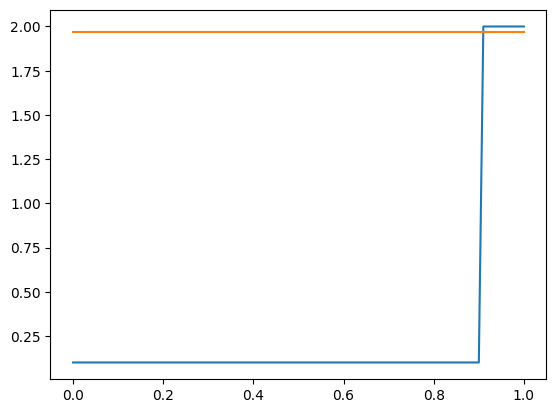

In [9]:
plt.plot(x_grid, U)
plt.plot(x_grid, V)
plt.show()

In [11]:
res = model.integrate([U, V], kinetics, 5)

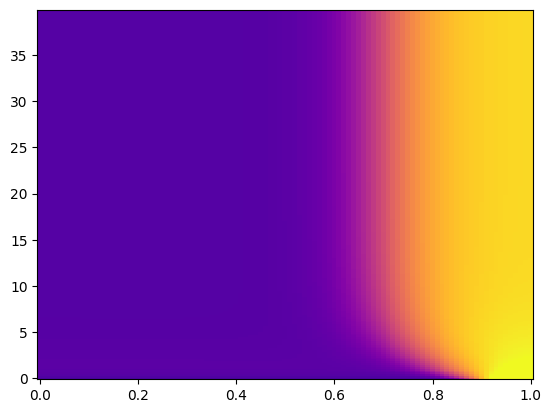

In [12]:
plt.pcolor(x_grid, t_grid, res[:,0,:], vmin=0., vmax=1.2, cmap='plasma')

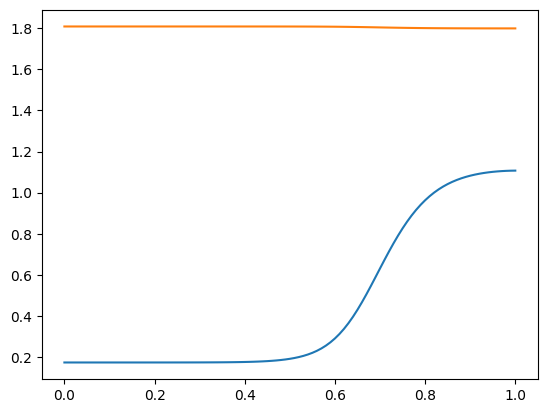

In [13]:
plt.plot(x_grid, res[-1, 0, :])
plt.plot(x_grid, res[-1, 1, :])
plt.show()

In [56]:
model = RD_2D_1st_Order(Ds=[0.01, 0.1], N=2*2500, T=2*10, Lx=1, Ly=1, Ix=100, Jy=100,
                        #boundary_condition=Neumann_Boundary_2D
                       #boundary_condition=Periodic_Boundary_2D
                        boundary_condition=Diritchlet_Boundary_2D
                       ,cx=1, cy=1)

In [19]:
A, B = 4.5, 13.29
def Brusselator1(u,v):    
    u2 = u**2
    u2v = u2 * v
    return A - (B + 1) * u + u2v
    
def Brusselator2(u,v):    
    u2 = u**2
    u2v = u2 * v
    return B * u - u2v

def kinetics(u,v):    
    u2 = u**2
    u2v = u2 * v
    return (A - (B + 1) * u + u2v, B * u - u2v)

U = np.random.normal(scale=.1, size=(model.Ix*model.Jy + model.Ix + model.Jy + 1))
U += A
V = np.random.normal(scale=.1, size=(model.Ix*model.Jy + model.Ix + model.Jy + 1 ))
V += B/A

In [57]:
res1 = model.integrate([U,V],kinetics, 1)

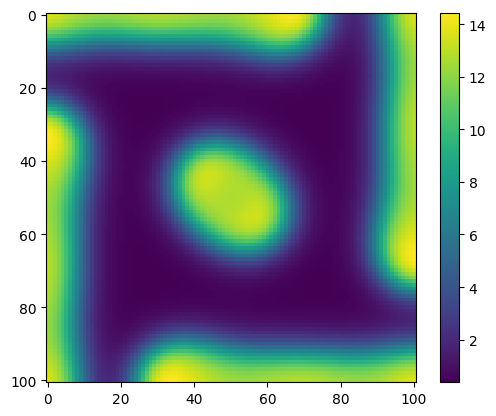

In [70]:
plt.imshow((res1[-1, 0, :]).reshape(model.Ix + 1, model.Jy + 1))
plt.colorbar()

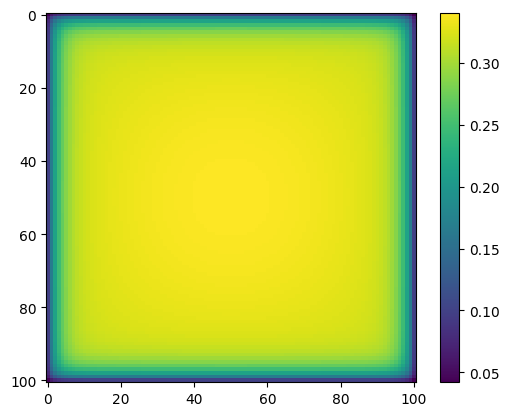

In [8]:
plt.imshow((res2[-1, 0, :]).reshape(model.Ix + 1, model.Jy + 1))
plt.colorbar()

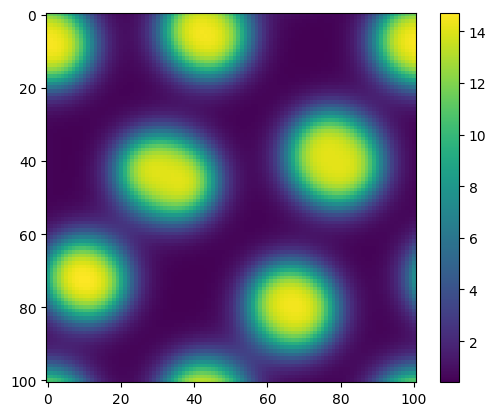

In [5]:
plt.imshow((res3[-1, 0, :]).reshape(model.Ix + 1, model.Jy + 1))
plt.colorbar()

In [13]:
model = RD_2D_1st_Order(Ds=[0.01, 0.1], N=2500, T=10, Lx=1, Ly=1, Ix=160, Jy=160,
                        #boundary_condition=Neumann_Boundary_2D)
                       boundary_condition=Periodic_Boundary_2D)
                        #boundary_condition=Diritchlet_Boundary_2D)
                       #,cx=1, cy=2)

In [3]:
from multiprocessing import Pool

In [23]:
def run_1(args):
    A,B = args
    U = np.random.normal(scale=.1, size=(model.Ix*model.Jy + model.Ix + model.Jy + 1))
    U += A
    V = np.random.normal(scale=.1, size=(model.Ix*model.Jy + model.Ix + model.Jy + 1 ))
    V += B/A
    def kinetics(u,v):    
        u2 = u**2
        u2v = u2 * v
        return (A - (B + 1) * u + u2v, B * u - u2v)
    return model.integrate([U,V],kinetics, 100)
                           
params = [[4.5, 3.0], [4.5, 6.0], [4.5, 8.0], [4.5, 10.0], [4.5, 13.29],
          [3.5, 3.0], [3.5, 6.0], [3.5, 8.0], [3.5, 10.0], [3.5, 13.29]]
                           
with Pool(14) as p:
    ret = p.map(run_1, params)

In [20]:
params = [[4.5, 3.0], [4.5, 6.0], [4.5, 8.0], [4.5, 10.0], [4.5, 13.29],
          [3.5, 3.0], [3.5, 6.0], [3.5, 8.0], [3.5, 10.0], [3.5, 13.29]]

def create_parame(A,B, model, record_steps=1):
    U = np.random.normal(scale=.1, size=(model.Ix*model.Jy + model.Ix + model.Jy + 1))
    U += A
    V = np.random.normal(scale=.1, size=(model.Ix*model.Jy + model.Ix + model.Jy + 1 ))
    V += B/A
    Us_ret = np.zeros(
            (
                model.N // record_steps,
                model.nodes,
                model.Ix*model.Jy + model.Ix + model.Jy + 1
            )            
        )    
    return (A, B,
            model.N, model.Δt,
            Us_ret,
            model.As.copy(), model.Bcsrs.copy(),
            [U, V], 
            model.BC2s.copy(), record_steps)

def run_2(args):
    A,B,N,Δt,Us_ret,As,Bcsrs, Us, BC2s,record_steps = args
    import scipy
    A_facts = [scipy.sparse.linalg.factorized(A) for A in As]
    def kinetics(u,v):    
        u2 = u**2
        u2v = u2 * v
        return (A - (B + 1) * u + u2v, B * u - u2v)
    
    return integrate_1st_order(
            N, Δt, Us_ret, A_facts, Bcsrs, Us, kinetics, BC2s, record_steps
        )

params = [create_parame(A,B, model, 10)  for A,B in params]

In [21]:
with Pool(14) as p:
    ret = p.map(run_2, params)

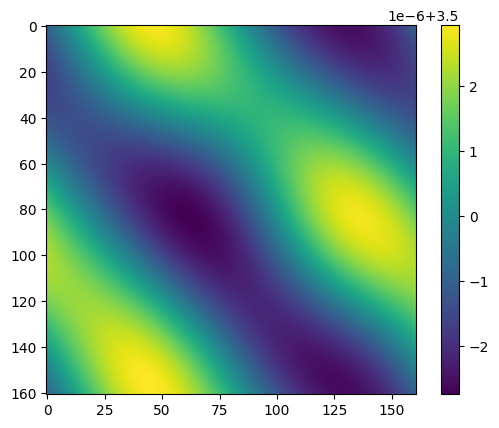

In [12]:
plt.imshow(ret[5][-1, 0, :].reshape(model.Ix + 1, model.Jy + 1))
plt.colorbar()

In [42]:
def Diritchlet_Boundary_2D(rx, ry, Ix, Jy, cx=0.0, cy=0.0, delta_x=0, delta_y=0):
    """Diritchlet boundary condition: u = 0

    Args:
        rx (float): D Δt / 2 Δx^2
        ry (float): D Δt / 2 Δx^2
                    Δt = T/N
                    Δx = Lx/I
                    Δy = Ly/J
        Ix (int): x direction Ix+1 discrete space points number
        Jy (int): y direction Jy+1 discrete space points number

    Returns:
        (IxJy + Ix + Jy)*(IxJy  + Ix + Jy) matrix: A matrix that must be added to A and subtracted from B
    """
    size = Ix * Jy + Ix + Jy + 1
    if cx == 0.0 and cy == 0.0:
        return (
              np.diagflat([-rx*cx] * (Jy + 1) + [0] * (size - 2 * Jy - 2) + [-rx*cx] * (Jy + 1))
            + np.diagflat(([-ry*cy] + [0] * (Ix - 1) + [-ry*cy]) * (Jy + 1))
            + first_order_term_corrections(rx, Ix, Jy), None)
    else:
        return (
              np.diagflat([-rx*cx] * (Jy + 1) + [0] * (size - 2 * Jy - 2) + [-rx*cx] * (Jy + 1))
            + np.diagflat(([-ry*cy] + [0] * (Ix - 1) + [-ry*cy]) * (Jy + 1))
            + first_order_term_corrections(rx, Ix, Jy),
            np.array(
                [2.0 * rx * cx * delta_x] * (Jy + 1) + [0] * (size - 2 * Jy - 2) + [2.0 * rx * cx * delta_x] * (Jy + 1)
            )
            + np.array(([2.0 * ry * cy * delta_y] + [0] * (Ix - 1) + [2.0 * ry * cy * delta_y]) * (Jy + 1)),
        )

In [46]:
Diritchlet_Boundary_2D(1,1,2,2, 0, 0, 1, 1)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 None)